In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [4]:
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
df = pd.concat([train,test])

## Analysis 

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [6]:
df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
train_test       int64
dtype: object

In [7]:
numeric = train.select_dtypes(exclude='object')
numeric.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [8]:
#correlation with prediction/target var

correlation = abs(numeric.corr()*100)
correlation[['Survived']].sort_values(['Survived'], ascending=False)


,Survived
Survived,100.000000
Pclass,33.848104
Fare,25.730652
Parch,8.162941
Age,7.722109
SibSp,3.532250
PassengerId,0.500666
train_test,NaN


<AxesSubplot:>

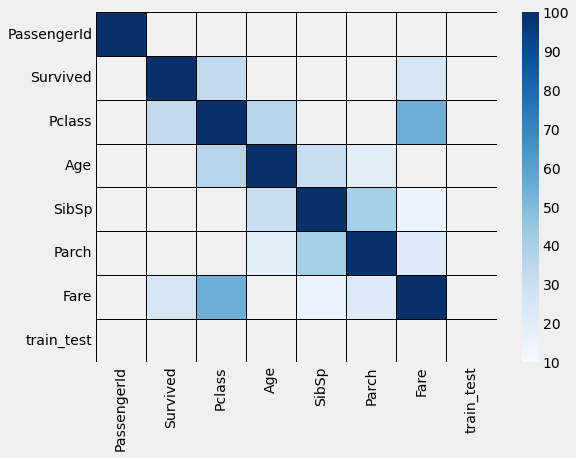

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation, mask=correlation<10, cmap='Blues', vmin=10, linewidths=.5, linecolor='k')

/Users/user/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


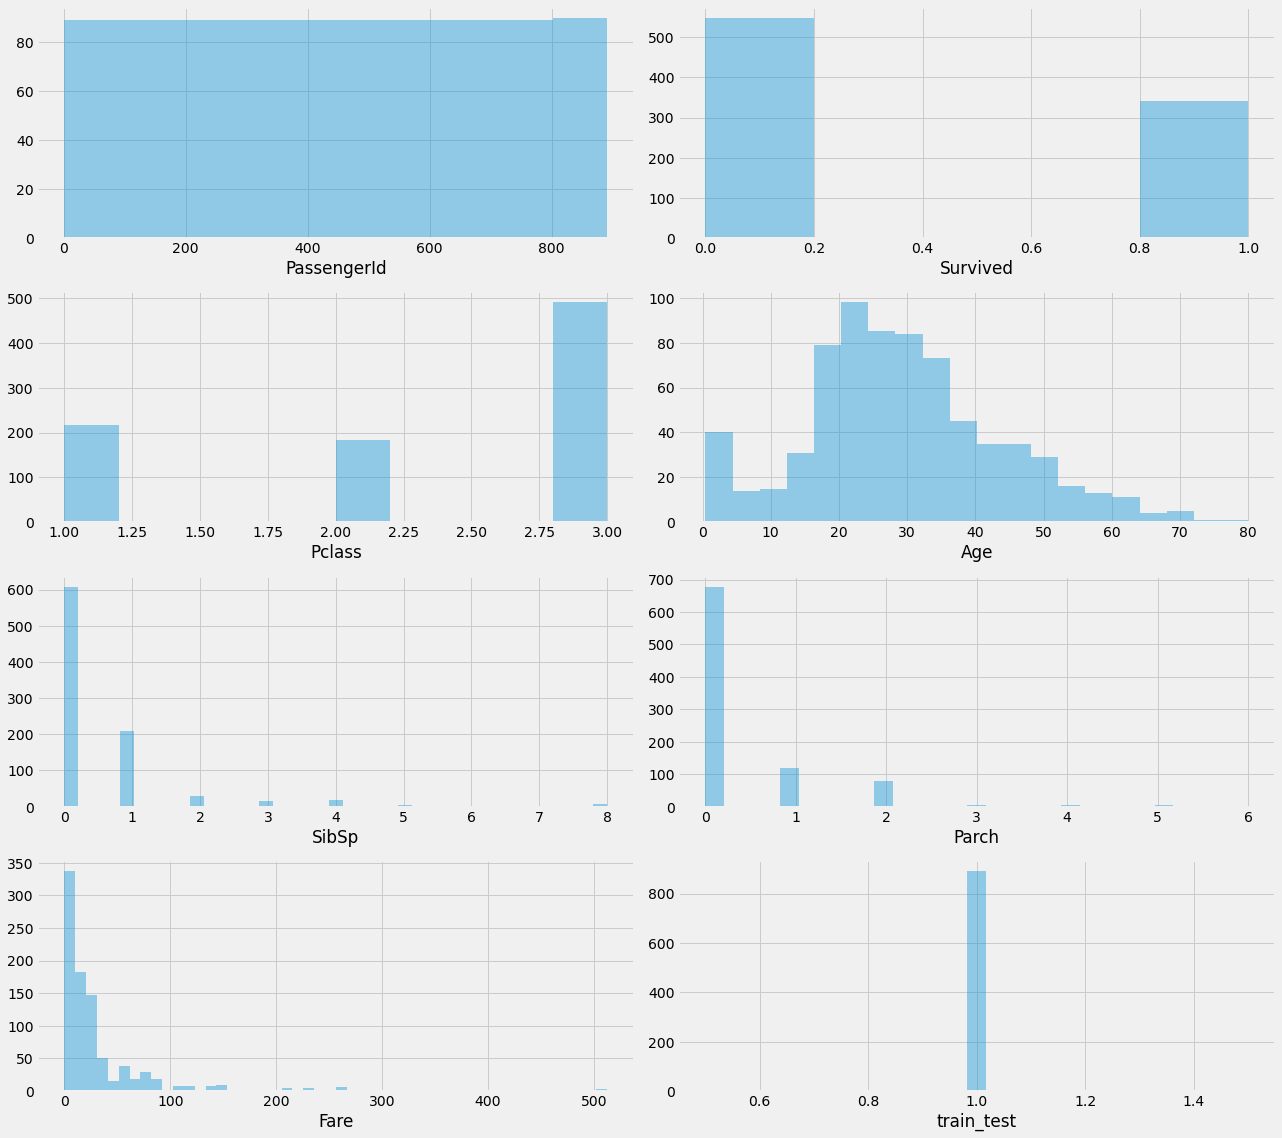

In [10]:
fig = plt.figure(figsize=(18,16))

for index, col in enumerate(numeric.columns):
     plt.subplot(4,2,index+1)
     sns.distplot(numeric.loc[:,col].dropna(), kde=False)
     
fig.tight_layout(pad=1.0)

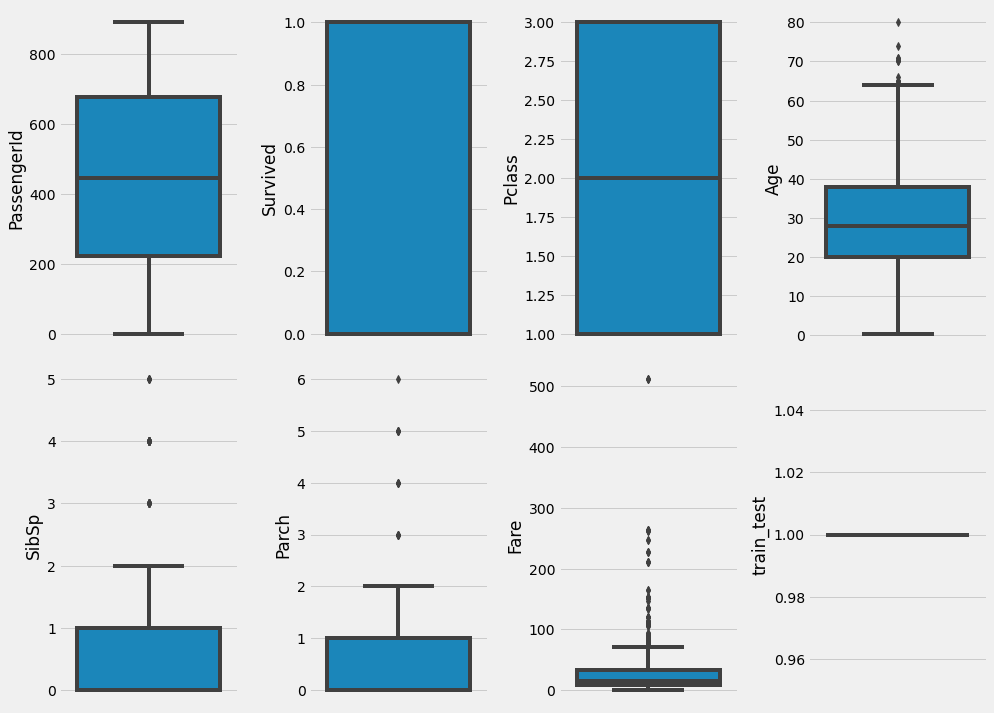

In [11]:
# Outliers 

fig =  plt.figure(figsize=(14,20))
for index , col in enumerate(numeric.columns):
    plt.subplot(4,4, index+1)
    sns.boxplot(y=col, data=numeric.dropna())
fig.tight_layout(pad=1.0)

In [12]:
cat = train.select_dtypes(include=['object']).copy()
cat['Pclass'] = train['Pclass']
cat = cat.drop(['Ticket', 'Cabin', 'Name'], axis=1) #droped knowing it has a lot of possible values
cat.columns

Index(['Sex', 'Embarked', 'Pclass'], dtype='object')

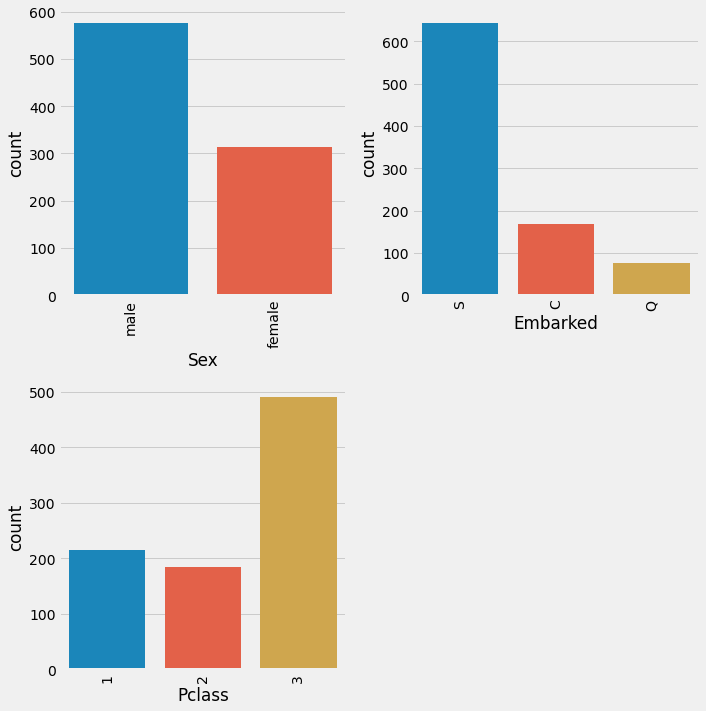

In [13]:
fig = plt.figure(figsize=(10,20))
for index in range(len(cat.columns)):
    plt.subplot(4,2,index+1)
    sns.countplot(x=cat.iloc[:,index],data=cat.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

## Transformation 

In [14]:
df.isnull().sum().nlargest(40)  

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
train_test        0
dtype: int64

In [15]:
df = df.drop(['Cabin'],axis=1)

In [16]:
#Filling missing Age values based on the median of the name tiltle (Mss. Mr. Mrs. etc)

import re
df['name_titles'] = df['Name'].apply(lambda x: re.findall(',\s(\w*).',x)[0])
df['Age'] = df.groupby('name_titles')['Age'].transform(lambda x: x.fillna(x.median()))

In [17]:
df['Embarked'] = df['Embarked'].fillna('S')
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [18]:
df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))

In [19]:
df.isnull().sum().nlargest(40) 

Survived       418
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
train_test       0
name_titles      0
dtype: int64

In [20]:
df['fam'] = df['SibSp']+ df['Parch']

In [21]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'name_titles', 'Embarked', 'SibSp', 'Parch'], axis=1)
df

,Survived,Pclass,Sex,Age,Fare,train_test,fam
0,0.0,3,male,22.0,7.2500,1,1
1,1.0,1,female,38.0,71.2833,1,1
2,1.0,3,female,26.0,7.9250,1,0
3,1.0,1,female,35.0,53.1000,1,1
4,0.0,3,male,35.0,8.0500,1,0
...,...,...,...,...,...,...,...
413,NaN,3,male,29.0,8.0500,0,0
414,NaN,1,female,39.0,108.9000,0,0
415,NaN,3,male,38.5,7.2500,0,0
416,NaN,3,male,29.0,8.0500,0,0


In [22]:
#converting Sex and Embarked into Binary 
df['Sex'] = np.where(df['Sex']== 'female', 1,0)
df = pd.get_dummies(df, columns=['Sex'])
df

,Survived,Pclass,Age,Fare,train_test,fam,Sex_0,Sex_1
0,0.0,3,22.0,7.2500,1,1,1,0
1,1.0,1,38.0,71.2833,1,1,0,1
2,1.0,3,26.0,7.9250,1,0,0,1
3,1.0,1,35.0,53.1000,1,1,0,1
4,0.0,3,35.0,8.0500,1,0,1,0
...,...,...,...,...,...,...,...,...
413,NaN,3,29.0,8.0500,0,0,1,0
414,NaN,1,39.0,108.9000,0,0,0,1
415,NaN,3,38.5,7.2500,0,0,1,0
416,NaN,3,29.0,8.0500,0,0,1,0


In [23]:
dfbin = df.copy()
dfbin['Fare'] = pd.qcut(dfbin['Fare'], 5)
dfbin = pd.get_dummies(dfbin, columns=['Fare', 'Pclass', 'fam'])
dfbin

,Survived,Age,train_test,Sex_0,Sex_1,"Fare_(-0.001, 7.854]","Fare_(7.854, 10.5]","Fare_(10.5, 21.558]","Fare_(21.558, 41.579]","Fare_(41.579, 512.329]",...,Pclass_3,fam_0,fam_1,fam_2,fam_3,fam_4,fam_5,fam_6,fam_7,fam_10
0,0.0,22.0,1,1,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,1.0,38.0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1.0,26.0,1,0,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,1.0,35.0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0.0,35.0,1,1,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,29.0,0,1,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
414,NaN,39.0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
415,NaN,38.5,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
416,NaN,29.0,0,1,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [24]:
# Separating Train and Test 

train_df = df[df['train_test']==1]
test_df = df[df['train_test']==0]
train_df = train_df.drop('train_test', axis=1)
test_df = test_df.drop('train_test', axis=1)

In [25]:
train_dfbin = dfbin[dfbin['train_test']==1]
test_dfbin = dfbin[dfbin['train_test']==0]
train_dfbin = train_dfbin.drop('train_test', axis=1)
test_dfbin = test_dfbin.drop('train_test', axis=1)

## Fitting the model 

In [26]:
train_dfbin_y = train_dfbin.Survived
train_dfbin_X = train_dfbin.drop(['Survived'], axis=1)

In [27]:
train_df_y = train_df.Survived
train_df_X = train_df.drop(['Survived'], axis=1)

train_df_X

,Pclass,Age,Fare,fam,Sex_0,Sex_1
0,3,22.0,7.2500,1,1,0
1,1,38.0,71.2833,1,0,1
2,3,26.0,7.9250,0,0,1
3,1,35.0,53.1000,1,0,1
4,3,35.0,8.0500,0,1,0
...,...,...,...,...,...,...
886,2,27.0,13.0000,0,1,0
887,1,19.0,30.0000,0,0,1
888,3,22.0,23.4500,3,0,1
889,1,26.0,30.0000,0,1,0


In [28]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection, metrics

model = GradientBoostingClassifier().fit(train_df_X, train_df_y)
accuracy =  round(model.score(train_df_X,train_df_y)*100,2)
cross_val = model_selection.cross_val_predict(GradientBoostingClassifier(n_estimators=150, learning_rate=0.1), train_df_X,train_df_y, cv=10, n_jobs=-1)
acc_cv = round(metrics.accuracy_score(train_df_y,cross_val)*100,2)
feature_ranks = pd.Series((model.feature_importances_)*100, index=train_df_X.columns).sort_values(ascending=False)

print('Acc ',accuracy )
print()
print('Cross val ', acc_cv)
print('Feature rank ')
print(feature_ranks)


Acc  89.67

Cross val  84.62
Feature rank 
Sex_1     24.076661
Sex_0     22.933807
Fare      17.025432
Pclass    14.650911
Age       12.053696
fam        9.259494
dtype: float64


In [31]:
# XG Boost 

import xgboost as xgb

/Users/user/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
xgb_model.fit(train_dfbin_X, train_dfbin_y, 
                verbose=True, early_stopping_rounds=10, eval_metric='aucpr')